In [88]:
import pyspark
%matplotlib inline

In [8]:
from pyspark.sql.functions import *

In [12]:
import numpy as np

### resource used for code in building models
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df_training = spark.read.csv('df_training_updated.csv', header = True, inferSchema = True)
df_training.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- hospital_death: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- hospital_admit_source: string (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- readmission_status: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- albumin_apache: double (nullable = true)
 |-- apache_2_diagnosis: double (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- arf_apache: double (nullable = true)
 |-- bilirubin_apache: double

In [15]:
df_training.groupBy('hospital_death').count().show()

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|             1| 7915|
|             0|83798|
+--------------+-----+



In [19]:
df_training.dtypes

[('encounter_id', 'int'),
 ('patient_id', 'int'),
 ('hospital_id', 'int'),
 ('hospital_death', 'int'),
 ('age', 'double'),
 ('bmi', 'double'),
 ('elective_surgery', 'int'),
 ('ethnicity', 'string'),
 ('gender', 'string'),
 ('height', 'double'),
 ('hospital_admit_source', 'string'),
 ('icu_admit_source', 'string'),
 ('icu_id', 'int'),
 ('icu_stay_type', 'string'),
 ('icu_type', 'string'),
 ('pre_icu_los_days', 'double'),
 ('readmission_status', 'int'),
 ('weight', 'double'),
 ('albumin_apache', 'double'),
 ('apache_2_diagnosis', 'double'),
 ('apache_3j_diagnosis', 'double'),
 ('arf_apache', 'double'),
 ('bilirubin_apache', 'double'),
 ('bun_apache', 'double'),
 ('creatinine_apache', 'double'),
 ('fio2_apache', 'double'),
 ('gcs_eyes_apache', 'double'),
 ('gcs_motor_apache', 'double'),
 ('gcs_unable_apache', 'double'),
 ('gcs_verbal_apache', 'double'),
 ('glucose_apache', 'double'),
 ('heart_rate_apache', 'double'),
 ('hematocrit_apache', 'double'),
 ('intubated_apache', 'double'),
 ('ma

In [20]:
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string']
print(categorical_features)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


In [45]:
numeric_features = [c for c in df_training.drop('label').columns if c not in categorical_features]
print(numeric_features)

['encounter_id', 'patient_id', 'hospital_id', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_temp_max', 'd1_temp_

In [28]:
df_training = df_training.withColumnRenamed('hospital_death', 'label')

In [65]:
# fill in nulls with 0 for now - will require updates

df_training = df_training.fillna('0')and

In [66]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

stages = []

for categoricalCol in categorical_features:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in categorical_features] + numeric_features
    
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [67]:
from pyspark.ml import Pipeline


pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_training)
df_training_transformed = pipelineModel.transform(df_training)
selectedCols = ['label', 'features'] + categorical_features + numeric_features
df_training_transformed = df_training_transformed.select(selectedCols)
df_training_transformed.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- ethnicity: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- hospital_admit_source: string (nullable = false)
 |-- icu_admit_source: string (nullable = false)
 |-- icu_stay_type: string (nullable = false)
 |-- icu_type: string (nullable = false)
 |-- apache_3j_bodysystem: string (nullable = false)
 |-- apache_2_bodysystem: string (nullable = false)
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- age: double (nullable = false)
 |-- bmi: double (nullable = false)
 |-- elective_surgery: integer (nullable = true)
 |-- height: double (nullable = false)
 |-- icu_id: integer (nullable = true)
 |-- pre_icu_los_days: double (nullable = false)
 |-- readmission_status: integer (nullable = true)
 |-- weight: double (nullable = false)
 |-- albumin_apache: double (nullable = false)
 |-- apache_2_diagnosis:

In [78]:
train, test = df_training_transformed.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 64204
Test Dataset Count: 27509


### Logistic Regression

In [79]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

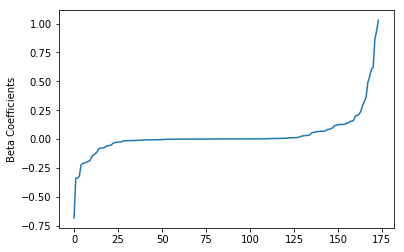

In [89]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

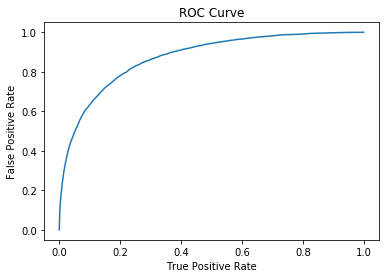

Training set areaUnderROC: 0.8726057933424342


In [90]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

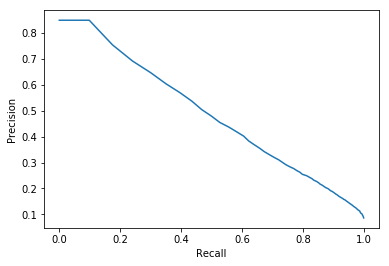

In [91]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [97]:
predictions = lrModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').toPandas()

,label,rawPrediction,prediction,probability
0,0,"[3.1656820111866404, -3.1656820111866404]",0.0,"[0.9595222091129615, 0.040477790887038505]"
1,0,"[1.8551969358917728, -1.8551969358917728]",0.0,"[0.8647361289263845, 0.1352638710736154]"
2,0,"[2.2677190744422853, -2.2677190744422853]",0.0,"[0.9061680258777114, 0.09383197412228858]"
3,0,"[0.6530253691155379, -0.6530253691155379]",0.0,"[0.6576918984778239, 0.34230810152217606]"
4,0,"[2.3364221541125194, -2.3364221541125194]",0.0,"[0.9118489197000188, 0.08815108029998117]"
5,0,"[2.0734477637113065, -2.0734477637113065]",0.0,"[0.8882955295248665, 0.11170447047513353]"
6,0,"[1.413023634503856, -1.413023634503856]",0.0,"[0.8042424121818879, 0.19575758781811217]"
7,0,"[3.0164519649509858, -3.0164519649509858]",0.0,"[0.953311862025107, 0.04668813797489297]"
8,0,"[2.122914528354743, -2.122914528354743]",0.0,"[0.8931104814322935, 0.1068895185677065]"
9,0,"[3.3649181275042355, -3.3649181275042355]",0.0,"[0.9665899667392236, 0.03341003326077631]"


In [95]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8722792315951601


### Decision Tree Classifier

In [100]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+----------------+----------+--------------------+
|label|   rawPrediction|prediction|         probability|
+-----+----------------+----------+--------------------+
|    0| [6774.0,1210.0]|       0.0|[0.84844689378757...|
|    0|[48565.0,1636.0]|       0.0|[0.96741100774884...|
|    0|  [1882.0,899.0]|       0.0|[0.67673498741459...|
|    0|   [456.0,184.0]|       0.0|     [0.7125,0.2875]|
|    0|[48565.0,1636.0]|       0.0|[0.96741100774884...|
|    0|[48565.0,1636.0]|       0.0|[0.96741100774884...|
|    0|[48565.0,1636.0]|       0.0|[0.96741100774884...|
|    0|[48565.0,1636.0]|       0.0|[0.96741100774884...|
|    0|   [456.0,184.0]|       0.0|     [0.7125,0.2875]|
|    0|[48565.0,1636.0]|       0.0|[0.96741100774884...|
+-----+----------------+----------+--------------------+
only showing top 10 rows



In [101]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.20865821212908284


### Random Forest Classifier

In [102]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[18.7994332120878...|       0.0|[0.93997166060439...|
|    0|[15.5246620944985...|       0.0|[0.77623310472492...|
|    0|[12.2925590341518...|       0.0|[0.61462795170759...|
|    0|[13.0008755314206...|       0.0|[0.65004377657103...|
|    0|[17.7402287333059...|       0.0|[0.88701143666529...|
|    0|[14.6249989546810...|       0.0|[0.73124994773405...|
|    0|[14.8599469708844...|       0.0|[0.74299734854422...|
|    0|[17.6954897592315...|       0.0|[0.88477448796157...|
|    0|[16.1187814918483...|       0.0|[0.80593907459241...|
|    0|[17.8272185801646...|       0.0|[0.89136092900823...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [103]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8632556070613883


### Gradient-Boosted Tree Classifier

In [104]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[0.98012400957318...|       0.0|[0.87655979128836...|
|    0|[1.00780154862630...|       0.0|[0.88242559404891...|
|    0|[0.57694148286113...|       0.0|[0.76021944164553...|
|    0|[0.46538977688223...|       0.0|[0.71723341328470...|
|    0|[1.08419107044785...|       0.0|[0.89737406744039...|
|    0|[0.87441661093556...|       0.0|[0.85180557670547...|
|    0|[0.79554285944183...|       0.0|[0.83076880127766...|
|    0|[1.04123824758996...|       0.0|[0.88918828378918...|
|    0|[0.34095909928139...|       0.0|[0.66416668489408...|
|    0|[1.13235213760186...|       0.0|[0.90591137084712...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [105]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8772852791323006


In [106]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0)

In [107]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8836087965503158

In [108]:
cvModel.avgMetrics

[0.845973989334342,
 0.8605462693328801,
 0.8468107911265681,
 0.8594115934970514,
 0.873170824507284,
 0.8791529479005377,
 0.8722178472761613,
 0.8780047085168807,
 0.878233864447928,
 0.8840749031513842,
 0.8764066034968803,
 0.8831277192592144]

In [111]:
bestModel = cvModel.bestModel

In [115]:
print('Best Param (MaxDepth): ', bestModel._java_obj.getMaxDepth())
print('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())
print('Best Param (MaxBins): ', bestModel._java_obj.getMaxBins())

Best Param (MaxDepth):  6
Best Param (MaxIter):  20
Best Param (MaxBins):  20


In [121]:
java_model = bestModel._java_obj
{param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]}

{'maxBins': 20, 'maxDepth': 6, 'maxIter': 20}

In [131]:
# from pyspark import SparkContext
# sc = SparkContext.getOrCreate()

bestModel.save("bestModel")

In [127]:
bestModel.featureImportances

SparseVector(174, {0: 0.001, 1: 0.0015, 2: 0.0007, 3: 0.0001, 5: 0.0, 8: 0.0012, 9: 0.0001, 12: 0.0006, 13: 0.0004, 15: 0.0011, 16: 0.0003, 17: 0.0021, 18: 0.0005, 22: 0.0004, 24: 0.0021, 25: 0.002, 26: 0.0041, 27: 0.0002, 29: 0.0018, 30: 0.0014, 31: 0.0038, 32: 0.0009, 33: 0.0005, 36: 0.0008, 37: 0.0029, 38: 0.0006, 39: 0.0027, 40: 0.0004, 43: 0.0004, 46: 0.0003, 47: 0.0001, 57: 0.0035, 58: 0.0036, 59: 0.0048, 60: 0.0318, 61: 0.0078, 63: 0.0045, 64: 0.0131, 65: 0.0084, 68: 0.0034, 69: 0.0146, 70: 0.029, 72: 0.0025, 73: 0.0109, 74: 0.0098, 75: 0.0204, 76: 0.0062, 77: 0.0128, 79: 0.0081, 80: 0.0081, 81: 0.003, 82: 0.0038, 83: 0.001, 84: 0.0076, 85: 0.0016, 86: 0.0019, 87: 0.0026, 88: 0.0072, 89: 0.0074, 90: 0.0056, 91: 0.0065, 92: 0.01, 93: 0.0127, 94: 0.0024, 95: 0.0069, 96: 0.0049, 97: 0.0053, 98: 0.008, 99: 0.0245, 100: 0.003, 101: 0.0009, 102: 0.0109, 103: 0.0132, 104: 0.0057, 105: 0.0239, 106: 0.0073, 107: 0.0314, 108: 0.0015, 109: 0.0013, 110: 0.014, 111: 0.0352, 112: 0.0222, 113:

In [135]:
from pyspark.ml.classification import GBTClassificationModel
Loadedmodel = GBTClassificationModel.load("bestModel")

In [136]:
Loadedmodel

GBTClassificationModel (uid=GBTClassifier_492e9d702cc7408b07d2) with 20 trees

In [140]:
import pandas as pd

# method copied from 
#https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/


def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [141]:
ExtractFeatureImp(bestModel.featureImportances, train, "features").head(10)


,idx,name,score
107,164,apache_4a_hospital_death_prob,0.198292
54,111,d1_sysbp_min,0.035187
3,60,age,0.031841
50,107,d1_spo2_min,0.031387
13,70,apache_3j_diagnosis,0.029041
42,99,d1_heartrate_min,0.024472
48,105,d1_resprate_min,0.023899
55,112,d1_temp_max,0.022220
108,165,apache_4a_icu_death_prob,0.020636
18,75,fio2_apache,0.020361


In [143]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# resource:  https://datascience.stackexchange.com/questions/40160/why-am-i-getting-the-same-value-for-the-accuracy-and-recall-when-using-sparks-m

accuracy_eval = MulticlassClassificationEvaluator(metricName = 'accuracy', labelCol='label')
recall_eval = MulticlassClassificationEvaluator(metricName = 'weightedRecall', labelCol='label')

print('dtc accuracy:', accuracy_eval.evaluate(predictions))
print('dtc recall', recall_eval.evaluate(predictions))

dtc accuracy: 0.926823948525937
dtc recall 0.926823948525937


In [147]:
print("areaUnderPR: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))

areaUnderPR: 0.5200622170408549


In [150]:
predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 5 rows



In [159]:
predictions.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1660|
|    0|       0.0|24778|
|    1|       1.0|  718|
|    0|       1.0|  353|
+-----+----------+-----+



In [153]:
TP = predictions.filter(col('label')==1).count()
FP = predictions.filter((col('label')==0)&(col('prediction')==1)).count()
FN = predictions.filter((col('label')==1)&(col('prediction')==0)).count()

Recall = TP/(TP+FN)
Precision = TP/(TP+FP)
F1 =  2*(Recall * Precision) / (Recall + Precision)

print("Recall: " + str(Recall))
print("Precision: " + str(Precision))
print("F1: " + str(F1))

Recall: 0.5889053987122338
Precision: 0.8707433174661297
F1: 0.7026148618702911


In [164]:
from sklearn.metrics import confusion_matrix
y_actu = np.array(predictions.select('label').collect())
y_pred =  np.array(predictions.select('prediction').collect())
confusion_matrix(y_actu, y_pred)

array([[24778,   353],
       [ 1660,   718]], dtype=int64)

[[24778   353]
 [ 1660   718]]


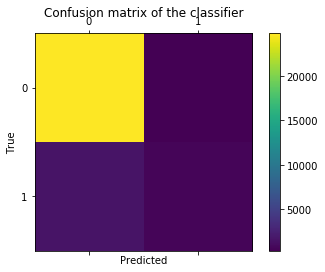

In [165]:
from sklearn.metrics import confusion_matrix

labels = [0,1]
cm = confusion_matrix(y_actu, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

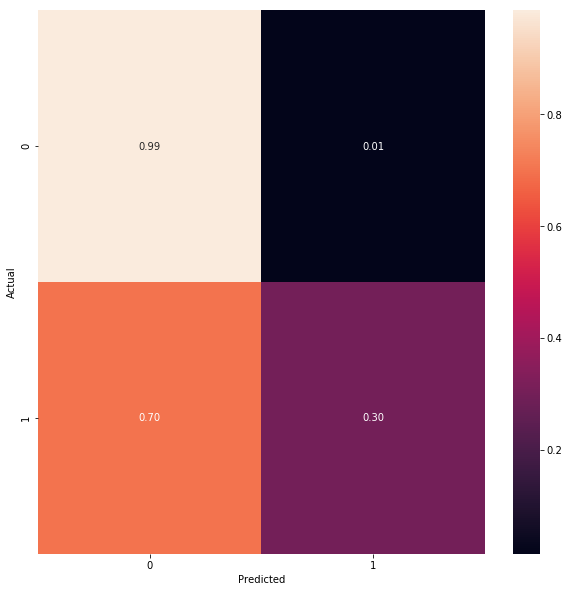

In [166]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_actu, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [167]:
print(cmn)

[[0.9859536 0.0140464]
 [0.6980656 0.3019344]]


In [145]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

metrics = BinaryClassificationMetrics(predictions)
print(metrics.areaUnderROC)
print(metrics.areaUnderPR)

#resource: https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html

AttributeError: 'DataFrame' object has no attribute 'ctx'

In [ ]:
## neural network

In [ ]:
stages = []

for categoricalCol in categorical_features:
    stringIndexer_tf = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder_tf = OneHotEncoderEstimator(inputCols=[stringIndexer_tf.getOutputCol()], outputCols=[categoricalCol + "classEncode"])
    stages_tf += [stringIndexer_tf, encoder_tf]

pipeline_tf = Pipeline(stages = stages_tf)
pipelineModel_tf = pipeline_tf.fit(df_training)
df_training_transformed_tf = pipelineModel_tf.transform(df_training)
# selectedCols = ['label'] + categorical_features + numeric_features
# df_training_transformed_tf = df_training_transformed_tf.select(selectedCols)
df_training_transformed_tf.printSchema()